In [1]:
import os
import spacy
from spacy import displacy
import en_core_sci_lg
from bin.parse_cde import parse_cde_json
from scispacy.abbreviation import AbbreviationDetector
from scispacy.linking import EntityLinker
import matplotlib.pyplot as plt

This notebook documents the process of determining how to best extract CUIs from CDEs using ScispaCy. In order to optimize parameters, we examine performance with varying parameters on two different CDEs: 
* "The indicator of whether the participant/subject has experienced a diabetic ketoacidosis (DKA) episode requiring emergency or urgent treatment, in the time since their diagnosis of diabetes."
* "Subject/Particpants *\[sic\]* amount of Glycosylated Hemoglobin (Hemoglobin A1c) in the blood"

The first is a CDE that takes numeric values -- for the purposes of our experiment, we designate this as a "continuous" CDE (it takes values over a range)

The second is a CDE that takes only Yes/No values -- for the purposes of experiment, we designate this as a "discrete" CDE. Other discrete CDEs might be, for example, medical survey questions that only allowed for a set number of predetermined answers.

The function get_cde_descriptions comes from binary file `parse_cde.py`, which is an in-progress portion of the eventual full-NLP pipeline. `parse_cde.py` takes in the JSON representation of a CDE and parses it for descriptive text about the CDE, classification information, "ids" (tbd) and acceptable values. After parsing this information, our first experiment is to try "translating" text entities to CUIs, a much more standardized form of medical expression.

# 1.1 - Extracting CUIs from descriptors in discrete and continuous CDEs

In [2]:
def get_cde_descriptions(filename):
    cde_content = parse_cde_json(filename)
    cde_descriptions = ''
    for string in cde_content['descriptive text']:
        cde_descriptions += string + ' /// '
    return cde_descriptions

In [3]:
discrete_cde_descriptions = get_cde_descriptions(os.path.join('data', 'sample_cdes', 'sample_cde_dka.json'))
continuous_cde_descriptions = get_cde_descriptions(os.path.join('data', 'sample_cdes', 'sample_cde_hba1c.json')
print(discrete_cde_descriptions + '\n\n--\n\n' + continuous_cde_descriptions)

The indicator of whether the participant/subject has experienced a diabetic ketoacidosis (DKA) episode requiring emergency or urgent treatment, in the time since their diagnosis of diabetes /// Diabetic ketoacidosis emergency post diagnosis diabetes indicator /// Since diagnosis have you/your child ever experienced diabetic ketoacidosis (high blood sugar plus ketones, also known as DKA) diagnosed by a doctor for which he/she went to either the hospital, emergency room, or another healthcare facility? /// 

--

Subject/Particpants amount of Glycosylated Hemoglobin (Hemoglobin A1c) in the blood. /// Laboratory procedure glycosylated hemoglobin value /// Glycosylated Hemoglobin (Hemoglobin A1c) /// Hemoglobin A1c /// Result /// 


The CUIs identified by ScispaCy can be compared to a set of manually tagged CUIs. With the caveat that I am not a medical professional and may not be the best judge of which CUIs are most appropriate, I have identified what I feel to be the top CUI candidates, with secondary choices also listed; text for CUIs is recorded at `misc/sample_cde_discrete_manual_cui_tags.txt` and `misc/sample_cde_continuous_manual_cui_tags.txt`

In [4]:
discrete_cde_target_cuis = ['C1522602', 'C1554105', 'C0679646', 'C4554048', 'C0681850', 'C0011880', 'C0011880', 'C0332189',
                            'C0013969', 'C0013956', 'C3272275', 'C0040223', 'C0687676', 'C0011900', 'C0011849', 'C4724242',
                            'C0020456', 'C0022634', 'C0031831', 'C0019994', 'C0562508', 'C0018704']
discrete_cde_all_manual_cuis = ['C1522602', 'C1554105', 'C0679646', 'C4554048', 'C0681850', 'C0011880', 'C0011880', 'C0332189',
                                'C0013969', 'C0013956', 'C3272275', 'C0040223', 'C0687676', 'C0011900', 'C0011849', 'C4724242',
                                'C0020456', 'C0022634', 'C0031831', 'C0019994', 'C0562508', 'C0018704', 'C1997894', 'C2349001',
                                'C2697811', 'C1550501', 'C0080105', 'C4684632', 'C1552741', 'C1698493', 'C1263959', 'C0745513',
                                'C0745514', 'C4728259', 'C2094155', 'C1527398', 'C0013956', 'C1553500', 'C1561585', 'C0013961', 
                                'C0013964', 'C0439609', 'C4047660', 'C1277189', 'C3541383', 'C1546899', 'C0011847', 'C0008059', 
                                'C0680063', 'C1546495', 'C0008100', 'C3843079', 'C1881306', 'C0202110', 'C2348314', 'C1547192',
                                'C0583237', 'C4291935', 'C4728259', 'C0184676']
continuous_cde_target_cuis = ['C0679646', 'C4554048', 'C0681850', 'C1265611', 'C0017853', 'C1821766', 'C1319284', 'C0005767', 
                              'C0022885', 'C1522609', 'C0456984', 'C0202054']
continuous_cde_all_manual_cuis = ['C0679646', 'C4554048', 'C0681850', 'C1265611', 'C0017853', 'C1821766', 'C1319284', 'C0005767', 
                                  'C0022885', 'C1522609', 'C0456984', 'C1997894', 'C2349001', 'C2697811', 'C1550501', 'C0080105', 
                                  'C4684632', 'C1552741', 'C1698493', 'C1264637', 'C1561574', 'C4505389', 'C0202054', 'C0474680',
                                  'C0005768', 'C1254361', 'C4283904', 'C2700391', 'C0022877', 'C1522609', 'C1274040']

In [5]:
def configure_nlp_pipeline(k, max_entities, threshold):
    med_nlp = spacy.load('en_core_sci_lg')
    abbreviation_pipe = AbbreviationDetector(med_nlp)
    med_nlp.add_pipe(abbreviation_pipe)
    linker = EntityLinker(name='umls', k=k, max_entities_per_mention=max_entities, threshold=threshold, resolve_abbreviations=True)
    med_nlp.add_pipe(linker)
    return med_nlp, linker

def evaluate_cui_detection(target_cuis, manual_cuis, processed_cde, linker):
    detected_cuis = []
    for entity in processed_cde.ents:
        for umls_ent in entity._.kb_ents:
            if umls_ent[0] not in detected_cuis:
                detected_cuis.append(umls_ent[0])
            
    total_detected_cuis, total_target_cuis, total_manual_cuis = len(detected_cuis), len(target_cuis), len(manual_cuis)
    
    target_matches = 0
    manual_matches = 0
    for cui in detected_cuis:
        if cui in target_cuis:
            target_matches += 1
        if cui in manual_cuis:
            manual_matches += 1

    print('{} of {} detected CUIs were in the list of target CUIs. Precision: {}'.format(target_matches, total_detected_cuis, target_matches/total_detected_cuis))
    print('{} of {} target CUIs were identified. Recall (Sensitivity): {}'.format(target_matches, total_target_cuis, target_matches/total_target_cuis))
    print('{} of {} detected CUIs were in the full list of manually tagged CUIs. Precision: {}'.format(manual_matches, total_detected_cuis, manual_matches/total_detected_cuis))
    print('{} of {} manually tagged CUIs were identified. Recall (Sensitivity): {}'.format(manual_matches, total_manual_cuis, manual_matches/total_manual_cuis))
    
    return detected_cuis


def display_cui_information(target_cuis, all_manual_cuis, detected_cuis):
    print('Detected target CUIs:\n')
    for cui in target_cuis:
        if cui in detected_cuis:
            print('>>', linker.kb.cui_to_entity[cui], end='\n\n')
    print('\n\n--------\n\nUndetected target CUIs:\n')
    for cui in target_cuis:
        if cui not in detected_cuis:
            print('>>', linker.kb.cui_to_entity[cui], end='\n\n')
    print('\n\n--------\n\nDetected CUIs not in target CUI group:\n')
    for cui in detected_cuis:
        if cui not in target_cuis:
            print('>>', linker.kb.cui_to_entity[cui], end='\n\n')
    print('\n\n--------\n\nDetected CUIs not in full manually tagged CUI group:\n')
    for cui in detected_cuis:
        if cui not in all_manual_cuis:
            print('>>', linker.kb.cui_to_entity[cui], end='\n\n')

At this point in the pipeline process, it is unclear if Recall or Precision is a more important factor. It is also worth noting that the k-means clustering is a stochastic progress, so results will vary between trials, even given the same parameters.

We examine the effects of changing three parameters in the ScispaCy pipeline:

1. k, the number of neighbors identified using ScispaCy's approximate nearest neighbor algorithm (default: 30)
2. max_entities_per_mention, "the maximum number of entities which will be returned for a given mention, regardless of how many are nearest neighbours are found." (default: 5)
3. threshold, a value determining the similarity threshold for a CUI and detected entity to be considered a match (default: 0.7)

_______

### Performance when varying k in k-nearest neighbors

k refers to the number of near neighbors that are found and considered as a candidate for linking in the approximate nearest neighbors algorithm that ScispaCy uses. Increasing this number increases runtime, but may also increase the quality of matches found.

##### Discrete CDE

In [11]:
med_nlp, linker = configure_nlp_pipeline(10, 2, 0.7)
discrete_processed_cde_10_2_7 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_10_2_7 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_10_2_7, linker)

C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


11 of 26 detected CUIs were in the list of target CUIs. Precision: 0.4230769230769231
11 of 22 target CUIs were identified. Recall (Sensitivity): 0.5
15 of 26 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.5769230769230769
15 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.25


C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\scispacy\candidate_generation.py:284: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  extended_neighbors[empty_vectors_boolean_flags] = numpy.array(neighbors)[:-1]
C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\scispacy\candidate_generation.py:285: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  extended_distances[empty_vectors_boolean_flags] = numpy.array(distances)[:-1]


In [12]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_10_2_7)

Detected target CUIs:

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketos

In [13]:
med_nlp, linker = configure_nlp_pipeline(20, 2, 0.7)
discrete_processed_cde_20_2_7 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_20_2_7 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_20_2_7, linker)

10 of 27 detected CUIs were in the list of target CUIs. Precision: 0.37037037037037035
10 of 22 target CUIs were identified. Recall (Sensitivity): 0.45454545454545453
14 of 27 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.5185185185185185
14 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.23333333333333334


In [14]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_20_2_7)

Detected target CUIs:

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketos

In [15]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.7)
discrete_processed_cde_30_2_7 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_30_2_7 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_30_2_7, linker)

11 of 27 detected CUIs were in the list of target CUIs. Precision: 0.4074074074074074
11 of 22 target CUIs were identified. Recall (Sensitivity): 0.5
15 of 27 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.5555555555555556
15 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.25


In [16]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_30_2_7)

Detected target CUIs:

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketos

In [17]:
med_nlp, linker = configure_nlp_pipeline(40, 2, 0.7)
discrete_processed_cde_40_2_7 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_40_2_7 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_40_2_7, linker)

12 of 27 detected CUIs were in the list of target CUIs. Precision: 0.4444444444444444
12 of 22 target CUIs were identified. Recall (Sensitivity): 0.5454545454545454
15 of 27 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.5555555555555556
15 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.25


In [18]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_40_2_7)

Detected target CUIs:

>> CUI: C1554105, Name: MDF Attribute Type - Indicator
Definition: <p>For attributes representing a specific condition as true or false.</p>
TUI(s): T078
Aliases: (total: 1): 
	 Indicator

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KE

In [19]:
med_nlp, linker = configure_nlp_pipeline(50, 2, 0.7)
discrete_processed_cde_50_2_7 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_50_2_7 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_50_2_7, linker)

11 of 27 detected CUIs were in the list of target CUIs. Precision: 0.4074074074074074
11 of 22 target CUIs were identified. Recall (Sensitivity): 0.5
14 of 27 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.5185185185185185
14 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.23333333333333334


In [20]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_50_2_7)

Detected target CUIs:

>> CUI: C1554105, Name: MDF Attribute Type - Indicator
Definition: <p>For attributes representing a specific condition as true or false.</p>
TUI(s): T078
Aliases: (total: 1): 
	 Indicator

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KE

##### Continuous CDE 

In [17]:
med_nlp, linker = configure_nlp_pipeline(10, 2, 0.7)
continuous_processed_cde_10_2_7 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_10_2_7 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_10_2_7, linker)

5 of 9 detected CUIs were in the list of target CUIs. Precision: 0.5555555555555556
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
6 of 9 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6666666666666666
6 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.1935483870967742


In [18]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_10_2_7)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

In [19]:
med_nlp, linker = configure_nlp_pipeline(20, 2, 0.7)
continuous_processed_cde_20_2_7 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_20_2_7 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_20_2_7, linker)

5 of 9 detected CUIs were in the list of target CUIs. Precision: 0.5555555555555556
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
6 of 9 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6666666666666666
6 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.1935483870967742


In [20]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_20_2_7)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

In [21]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.7)
continuous_processed_cde_30_2_7 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_30_2_7 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_30_2_7, linker)

5 of 9 detected CUIs were in the list of target CUIs. Precision: 0.5555555555555556
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
6 of 9 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6666666666666666
6 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.1935483870967742


In [22]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_30_2_7)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

In [23]:
med_nlp, linker = configure_nlp_pipeline(40, 2, 0.7)
continuous_processed_cde_40_2_7 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_40_2_7 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_40_2_7, linker)

5 of 9 detected CUIs were in the list of target CUIs. Precision: 0.5555555555555556
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
6 of 9 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6666666666666666
6 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.1935483870967742


In [24]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_40_2_7)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

In [25]:
med_nlp, linker = configure_nlp_pipeline(50, 2, 0.7)
continuous_processed_cde_50_2_7 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_50_2_7 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_50_2_7, linker)

5 of 9 detected CUIs were in the list of target CUIs. Precision: 0.5555555555555556
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
6 of 9 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6666666666666666
6 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.1935483870967742


In [26]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_50_2_7)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

### Performance when varying similarity thresholds for matching:

##### Discrete CDE

In [21]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.5)
discrete_processed_cde_30_2_5 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_30_2_5 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_30_2_5, linker)

12 of 31 detected CUIs were in the list of target CUIs. Precision: 0.3870967741935484
12 of 22 target CUIs were identified. Recall (Sensitivity): 0.5454545454545454
16 of 31 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.5161290322580645
16 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.26666666666666666


In [22]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_30_2_5)

Detected target CUIs:

>> CUI: C1554105, Name: MDF Attribute Type - Indicator
Definition: <p>For attributes representing a specific condition as true or false.</p>
TUI(s): T078
Aliases: (total: 1): 
	 Indicator

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KE

In [23]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.6)
discrete_processed_cde_30_2_6 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_30_2_6 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_30_2_6, linker)

11 of 30 detected CUIs were in the list of target CUIs. Precision: 0.36666666666666664
11 of 22 target CUIs were identified. Recall (Sensitivity): 0.5
16 of 30 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.5333333333333333
16 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.26666666666666666


In [24]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_30_2_6)

Detected target CUIs:

>> CUI: C1554105, Name: MDF Attribute Type - Indicator
Definition: <p>For attributes representing a specific condition as true or false.</p>
TUI(s): T078
Aliases: (total: 1): 
	 Indicator

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KE

In [25]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.8)
discrete_processed_cde_30_2_8 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_30_2_8 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_30_2_8, linker)

11 of 25 detected CUIs were in the list of target CUIs. Precision: 0.44
11 of 22 target CUIs were identified. Recall (Sensitivity): 0.5
14 of 25 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.56
14 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.23333333333333334


In [26]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_30_2_8)

Detected target CUIs:

>> CUI: C1554105, Name: MDF Attribute Type - Indicator
Definition: <p>For attributes representing a specific condition as true or false.</p>
TUI(s): T078
Aliases: (total: 1): 
	 Indicator

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KE

In [27]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.9)
discrete_processed_cde_30_2_9 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_30_2_9 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_30_2_9, linker)

11 of 21 detected CUIs were in the list of target CUIs. Precision: 0.5238095238095238
11 of 22 target CUIs were identified. Recall (Sensitivity): 0.5
14 of 21 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6666666666666666
14 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.23333333333333334


In [28]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_30_2_9)

Detected target CUIs:

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketos

##### Continuous CDE

In [27]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.5)
continuous_processed_cde_30_2_5 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_30_2_5 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_30_2_5, linker)

5 of 9 detected CUIs were in the list of target CUIs. Precision: 0.5555555555555556
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
6 of 9 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6666666666666666
6 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.1935483870967742


In [28]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_30_2_5)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

In [29]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.6)
continuous_processed_cde_30_2_6 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_30_2_6 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_30_2_6, linker)

5 of 9 detected CUIs were in the list of target CUIs. Precision: 0.5555555555555556
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
6 of 9 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6666666666666666
6 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.1935483870967742


In [30]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_30_2_6)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

In [31]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.8)
continuous_processed_cde_30_2_8 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_30_2_8 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_30_2_8, linker)

5 of 9 detected CUIs were in the list of target CUIs. Precision: 0.5555555555555556
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
6 of 9 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6666666666666666
6 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.1935483870967742


In [32]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_30_2_8)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

In [33]:
med_nlp, linker = configure_nlp_pipeline(30, 2, 0.9)
continuous_processed_cde_30_2_9 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_30_2_9 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_30_2_9, linker)

5 of 8 detected CUIs were in the list of target CUIs. Precision: 0.625
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
6 of 8 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.75
6 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.1935483870967742


In [34]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_30_2_9)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

### Performance when varying the number of CUI matches allowed per entity

##### Discrete CDE

In [29]:
med_nlp, linker = configure_nlp_pipeline(30, 1, 0.7)
discrete_processed_cde_30_1_7 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_30_1_7 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_30_1_7, linker)

10 of 13 detected CUIs were in the list of target CUIs. Precision: 0.7692307692307693
10 of 22 target CUIs were identified. Recall (Sensitivity): 0.45454545454545453
11 of 13 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.8461538461538461
11 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.18333333333333332


In [30]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_30_1_7)

Detected target CUIs:

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketos

In [31]:
med_nlp, linker = configure_nlp_pipeline(30, 3, 0.7)
discrete_processed_cde_30_3_7 = med_nlp(discrete_cde_descriptions)
discrete_detected_cuis_30_3_7 = evaluate_cui_detection(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_processed_cde_30_3_7, linker)

11 of 41 detected CUIs were in the list of target CUIs. Precision: 0.2682926829268293
11 of 22 target CUIs were identified. Recall (Sensitivity): 0.5
17 of 41 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.4146341463414634
17 of 60 manually tagged CUIs were identified. Recall (Sensitivity): 0.2833333333333333


In [32]:
display_cui_information(discrete_cde_target_cuis, discrete_cde_all_manual_cuis, discrete_detected_cuis_30_3_7)

Detected target CUIs:

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketoses, Diabetic, Diabetes Mellitus with Ketoacidosis, ACIDOSIS DIABETIC, Diabetic keto-acidosis, Diabetic acidosis, Acidosis, Diabetic

>> CUI: C0011880, Name: Diabetic Ketoacidosis
Definition: A life-threatening complication of diabetes mellitus, primarily of TYPE 1 DIABETES MELLITUS with severe INSULIN deficiency and extreme HYPERGLYCEMIA. It is characterized by KETOSIS; DEHYDRATION; and depressed consciousness leading to COMA.
TUI(s): T047
Aliases (abbreviated, total: 37): 
	 Diabetic Ketoses, diabetic ketoacidosis, DKA, DIABETIC KETOACIDOSIS, Ketos

##### Continuous CDE

In [10]:
med_nlp, linker = configure_nlp_pipeline(30, 1, 0.7)
continuous_processed_cde_30_1_7 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_30_1_7 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_30_1_7, linker)

C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


3 of 4 detected CUIs were in the list of target CUIs. Precision: 0.75
3 of 12 target CUIs were identified. Recall (Sensitivity): 0.25
4 of 4 detected CUIs were in the full list of manually tagged CUIs. Precision: 1.0
4 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.12903225806451613


C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\scispacy\candidate_generation.py:284: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  extended_neighbors[empty_vectors_boolean_flags] = numpy.array(neighbors)[:-1]
C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\scispacy\candidate_generation.py:285: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  extended_distances[empty_vectors_boolean_flags] = numpy.array(distances)[:-1]


In [11]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_30_1_7)

Detected target CUIs:

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, Name: Laboratory Procedures
Definition: Any procedure that involves testing or manipulating a sample of blood, urine, or other body substance in a laboratory setting.
TUI(s): T059
Aliases (abbreviated, total: 32): 
	 Laboratory procedure (procedure), Test, Laboratory procedures -general (situation), Laboratory test (procedure), lab tests, lab test, General laboratory procedure, NOS, Laboratory procedure, Laboratory Procedures, laboratory testing

>> CUI: C0202054, Name: Glucohemoglobin measurement
Definition: A quantitative measurement of the amount of glycosylated hemoglobin present in a sample of blood.
TUI(s): T059
Aliases (abbreviated, total: 15): 
	 Glycated haemog

In [12]:
med_nlp, linker = configure_nlp_pipeline(30, 3, 0.7)
continuous_processed_cde_30_3_7 = med_nlp(continuous_cde_descriptions)
continuous_detected_cuis_30_3_7 = evaluate_cui_detection(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_processed_cde_30_3_7, linker)

5 of 13 detected CUIs were in the list of target CUIs. Precision: 0.38461538461538464
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
8 of 13 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6153846153846154
8 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.25806451612903225


In [13]:
display_cui_information(continuous_cde_target_cuis, continuous_cde_all_manual_cuis, continuous_detected_cuis_30_3_7)

Detected target CUIs:

>> CUI: C1265611, Name: Quantity
Definition: How much there is of something that you can measure; the total amount or number.
TUI(s): T081
Aliases (abbreviated, total: 12): 
	 Quantity finding, How Much, quantities, amounts, Quantity finding (finding), How Many, Quantity, QUANTITIES, Amount, Quantity (attribute)

>> CUI: C0017853, Name: Hemoglobin, Glycosylated
Definition: None
TUI(s): T116, T123
Aliases (abbreviated, total: 21): 
	 Glycosylated Hb, Glycosylated hemoglobin, Glycated Hb, glycosylate hemoglobin, Glycosylated hemoglobin (substance), glycosylated haemoglobin, Glycated hemoglobin (substance), Hemoglobins, Glycated, Glycated hemoglobin, glycated haemoglobin

>> CUI: C0005767, Name: Blood
Definition: The body fluid that circulates in the vascular system (BLOOD VESSELS). Whole blood includes PLASMA and BLOOD CELLS.
TUI(s): T031
Aliases: (total: 8): 
	 Blood, Portion of blood, Haema, Blood, NOS, BLOOD, blood, Sanguis, Blood (substance)

>> CUI: C0022885, 

_____

# 1.2 - Visualizing Results

The information above is helpful to examine performance on individual trials, but a more global view of the impact of parameters on CUI extraction performance is necessary to make any meaningful decision. We visualize the results below:

In [6]:
def graph_precisions_recalls(parameter_name, parameter_list, detected_cuis_list, target_cuis, all_manual_cuis):
    x_vals = parameter_list
    y_precision_target = []
    y_recall_target = []
    y_precision_allmanual = []
    y_recall_allmanual = []
    
    num_targets = len(target_cuis)
    num_manuals = len(all_manual_cuis)
    
    for detected_cui_set in detected_cuis_list:
        num_detected = len(detected_cui_set)
        target_matches = 0
        manual_matches = 0
        for cui in detected_cui_set:
            if cui in target_cuis:
                target_matches += 1
            if cui in all_manual_cuis:
                manual_matches += 1
        y_precision_target.append(target_matches / num_detected)
        y_recall_target.append(target_matches / num_targets)
        y_precision_allmanual.append(manual_matches / num_detected)
        y_recall_allmanual.append(manual_matches / num_manuals)
        
    fig, ax = plt.subplots()
    ax.plot(x_vals, y_precision_target, color='r', label='Precision (target CUIs)')
    ax.plot(x_vals, y_precision_allmanual, color='g', label='Precision (all manual CUIs)')
    ax.plot(x_vals, y_recall_target, color='m', label='Recall (target CUIs)')
    ax.plot(x_vals, y_recall_allmanual, color='b', label='Recall (all manual CUIs)')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel(parameter_name)
    plt.show()
    return fig, ax

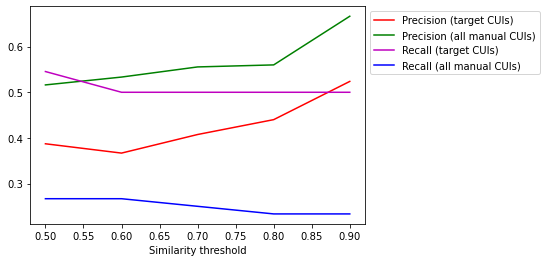

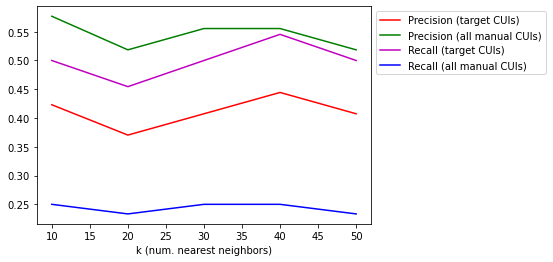

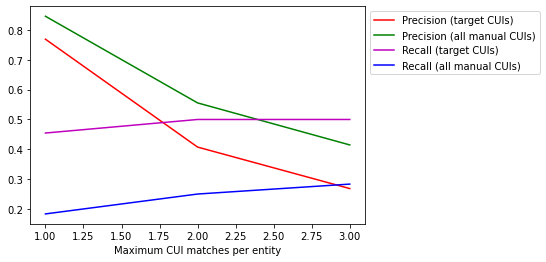

In [35]:
threshold_vals = [0.5, 0.6, 0.7, 0.8, 0.9]
k_vals = [10, 20, 30, 40, 50]
max_entity_vals = [1, 2, 3]

threshold_detected_cuis = [discrete_detected_cuis_30_2_5, discrete_detected_cuis_30_2_6, discrete_detected_cuis_30_2_7, discrete_detected_cuis_30_2_8, discrete_detected_cuis_30_2_9]
k_detected_cuis = [discrete_detected_cuis_10_2_7, discrete_detected_cuis_20_2_7, discrete_detected_cuis_30_2_7, discrete_detected_cuis_40_2_7, discrete_detected_cuis_50_2_7]
max_entity_detected_cuis = [discrete_detected_cuis_30_1_7, discrete_detected_cuis_30_2_7, discrete_detected_cuis_30_3_7]

threshold_fig, threshold_ax = graph_precisions_recalls('Similarity threshold', threshold_vals, threshold_detected_cuis, discrete_cde_target_cuis, discrete_cde_all_manual_cuis)
k_fig, k_ax = graph_precisions_recalls('k (num. nearest neighbors)', k_vals, k_detected_cuis, discrete_cde_target_cuis, discrete_cde_all_manual_cuis)
max_entity_fig, max_entity_ax = graph_precisions_recalls('Maximum CUI matches per entity', max_entity_vals, max_entity_detected_cuis, discrete_cde_target_cuis, discrete_cde_all_manual_cuis)

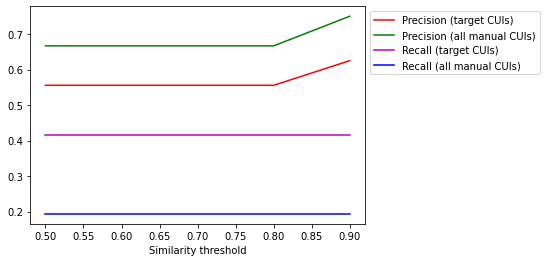

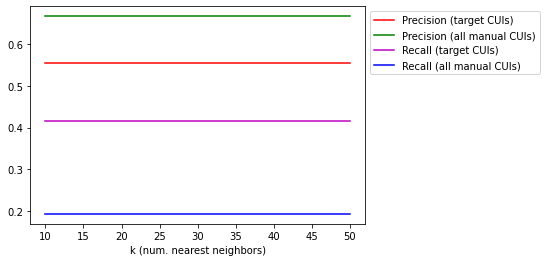

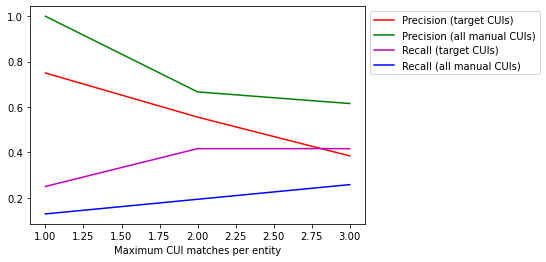

In [18]:
threshold_vals = [0.5, 0.6, 0.7, 0.8, 0.9]
k_vals = [10, 20, 30, 40, 50]
max_entity_vals = [1, 2, 3]

threshold_detected_cuis = [continuous_detected_cuis_30_2_5, continuous_detected_cuis_30_2_6, continuous_detected_cuis_30_2_7, continuous_detected_cuis_30_2_8, continuous_detected_cuis_30_2_9]
k_detected_cuis = [continuous_detected_cuis_10_2_7, continuous_detected_cuis_20_2_7, continuous_detected_cuis_30_2_7, continuous_detected_cuis_40_2_7, continuous_detected_cuis_50_2_7]
max_entity_detected_cuis = [continuous_detected_cuis_30_1_7, continuous_detected_cuis_30_2_7, continuous_detected_cuis_30_3_7]

threshold_fig, threshold_ax = graph_precisions_recalls('Similarity threshold', threshold_vals, threshold_detected_cuis, continuous_cde_target_cuis, continuous_cde_all_manual_cuis)
k_fig, k_ax = graph_precisions_recalls('k (num. nearest neighbors)', k_vals, k_detected_cuis, continuous_cde_target_cuis, continuous_cde_all_manual_cuis)
max_entity_fig, max_entity_ax = graph_precisions_recalls('Maximum CUI matches per entity', max_entity_vals, max_entity_detected_cuis, continuous_cde_target_cuis, continuous_cde_all_manual_cuis)

We use the graphs above to take a guess at what an optimal set of parameters might be. It is worth noting, however, that in an initial run of this process (while finalizing the code), results for the discrete CDE were quite different, suggesting that 50 nearest neighbors was a better option.

From the graphs above, we select `k = 40` (higher runtime but should produce better results), `max_entities = 1`, and `threshold = 0.9`

In [13]:
best_params = (40, 1, 0.9)
best_nlp, linker = configure_nlp_pipeline(*best_params)
best_discrete_processed_cde = best_nlp(discrete_cde_descriptions)
best_continuous_processed_cde = best_nlp(continuous_cde_descriptions)

C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\scispacy\candidate_generation.py:284: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  extended_neighbors[empty_vectors_boolean_flags] = numpy.array(neighbors)[:-

In [8]:
displacy.render(best_discrete_processed_cde, style='ent', jupyter=True)

for entity in best_discrete_processed_cde.ents:
    for umls_ent in entity._.kb_ents:
        cui = umls_ent[0]
        score = umls_ent[1]
        print(entity, '->', linker.kb.cui_to_entity[cui][1], '(' + linker.kb.cui_to_entity[cui][0] + ', ' + str(score) + ')', end=', ')

indicator -> Indicators (C0021212, 1.0), diabetic ketoacidosis -> Diabetic Ketoacidosis (C0011880, 1.0), DKA -> Diabetic Ketoacidosis (C0011880, 1.0), emergency -> Encounter Admission Source - emergency (C1546399, 1.0), diagnosis -> Diagnosis Study (C1704656, 0.9999998807907104), diabetes -> Diabetes (C0011847, 0.9999999403953552), Diabetic ketoacidosis -> Diabetic Ketoacidosis (C0011880, 1.0), emergency -> Encounter Admission Source - emergency (C1546399, 1.0), post -> Post (C0687676, 1.0), indicator -> Indicators (C0021212, 1.0), diagnosis -> Diagnosis Study (C1704656, 0.9999998807907104), diabetic ketoacidosis -> Diabetic Ketoacidosis (C0011880, 1.0), high blood sugar plus -> Hyperglycemia (C0020456, 0.9092411398887634), ketones -> Ketone Measurement (C1881306, 1.0), DKA -> Diabetic Ketoacidosis (C0011880, 1.0), diagnosed -> Diagnosis (C0011900, 1.0), doctor -> Doctor - Title (C2348314, 1.0), hospital -> Hospitals (C0019994, 1.0), emergency room -> Accident and Emergency department 

In [9]:
displacy.render(best_continuous_processed_cde, style='ent', jupyter=True)

for entity in best_continuous_processed_cde.ents:
    for umls_ent in entity._.kb_ents:
        cui = umls_ent[0]
        score = umls_ent[1]
        print(entity, '->', linker.kb.cui_to_entity[cui][1], '(' + linker.kb.cui_to_entity[cui][0] + ', ' + str(score) + ')', end=', ')

amount -> Quantity (C1265611, 0.9999998807907104), Glycosylated Hemoglobin -> Hemoglobin, Glycosylated (C0017853, 0.9999998807907104), Hemoglobin A1c -> Glycosylated hemoglobin A (C0019018, 1.0), blood -> Blood (C0005767, 1.0), Laboratory procedure -> Laboratory Procedures (C0022885, 1.0), Glycosylated Hemoglobin -> Hemoglobin, Glycosylated (C0017853, 0.9999998807907104), Hemoglobin A1c -> Glycosylated hemoglobin A (C0019018, 1.0), Hemoglobin A1c -> Glycosylated hemoglobin A (C0019018, 1.0), 

## 1.3  - Filtering for definitions

ScispaCy also offers an option to remove the filter (higher threshold level) for UMLS CUIs with no definition. We compare performance on a few different parameter sets between filter/no filter to determine which is the better option:

In [6]:
def compare_filters(k, max_entities_per_mention, threshold, cde_descriptions, target_cuis, manual_cuis):
    nofilter_nlp = spacy.load('en_core_sci_lg')
    abbreviation_pipe = AbbreviationDetector(nofilter_nlp)
    nofilter_nlp.add_pipe(abbreviation_pipe)
    nofilter_linker = EntityLinker(name='umls', k=k, max_entities_per_mention=max_entities_per_mention, threshold=threshold, resolve_abbreviations=True, filter_for_definitions=False)
    nofilter_nlp.add_pipe(nofilter_linker)
    
    filter_nlp = spacy.load('en_core_sci_lg')
    abbreviation_pipe = AbbreviationDetector(filter_nlp)
    filter_nlp.add_pipe(abbreviation_pipe)
    filter_linker = EntityLinker(name='umls', k=k, max_entities_per_mention=max_entities_per_mention, threshold=threshold, resolve_abbreviations=True, filter_for_definitions=True)
    filter_nlp.add_pipe(filter_linker)
    
    nofilter_processed_cde = nofilter_nlp(cde_descriptions)
    filter_processed_cde = filter_nlp(cde_descriptions)
    
    print('No filter for undefined CUIs: \n--------------')
    nofilter_detected_cuis = evaluate_cui_detection(target_cuis, manual_cuis, nofilter_processed_cde, nofilter_linker)
    print('\n\nFilter for undefined CUIs: \n-------------')
    filter_detected_cuis = evaluate_cui_detection(target_cuis, manual_cuis, filter_processed_cde, filter_linker)
    return None

In [25]:
compare_filters(30, 1, 0.9, continuous_cde_descriptions, continuous_cde_target_cuis, continuous_cde_all_manual_cuis)

No filter for undefined CUIs: 
--------------
3 of 4 detected CUIs were in the list of target CUIs. Precision: 0.75
3 of 12 target CUIs were identified. Recall (Sensitivity): 0.25
3 of 4 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.75
3 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.0967741935483871


Filter for undefined CUIs: 
-------------
4 of 5 detected CUIs were in the list of target CUIs. Precision: 0.8
4 of 12 target CUIs were identified. Recall (Sensitivity): 0.3333333333333333
5 of 5 detected CUIs were in the full list of manually tagged CUIs. Precision: 1.0
5 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.16129032258064516


In [7]:
compare_filters(30, 1, 0.9, continuous_cde_descriptions, continuous_cde_target_cuis, continuous_cde_all_manual_cuis)

C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\nlp_pipeline\lib\site-packages\scispacy\candidate_generation.py:284: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  extended_neighbors[empty_vectors_boolean_flags] = numpy.array(neighbors)[:-

No filter for undefined CUIs: 
--------------
4 of 4 detected CUIs were in the list of target CUIs. Precision: 1.0
4 of 12 target CUIs were identified. Recall (Sensitivity): 0.3333333333333333
4 of 4 detected CUIs were in the full list of manually tagged CUIs. Precision: 1.0
4 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.12903225806451613


Filter for undefined CUIs: 
-------------
5 of 5 detected CUIs were in the list of target CUIs. Precision: 1.0
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
5 of 5 detected CUIs were in the full list of manually tagged CUIs. Precision: 1.0
5 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.16129032258064516


In [23]:
compare_filters(40, 1, 0.9, continuous_cde_descriptions, continuous_cde_target_cuis, continuous_cde_all_manual_cuis)

No filter for undefined CUIs: 
--------------
4 of 5 detected CUIs were in the list of target CUIs. Precision: 0.8
4 of 12 target CUIs were identified. Recall (Sensitivity): 0.3333333333333333
5 of 5 detected CUIs were in the full list of manually tagged CUIs. Precision: 1.0
5 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.16129032258064516


Filter for undefined CUIs: 
-------------
4 of 5 detected CUIs were in the list of target CUIs. Precision: 0.8
4 of 12 target CUIs were identified. Recall (Sensitivity): 0.3333333333333333
4 of 5 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.8
4 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.12903225806451613


In [8]:
compare_filters(40, 1, 0.9, continuous_cde_descriptions, continuous_cde_target_cuis, continuous_cde_all_manual_cuis)

No filter for undefined CUIs: 
--------------
4 of 4 detected CUIs were in the list of target CUIs. Precision: 1.0
4 of 12 target CUIs were identified. Recall (Sensitivity): 0.3333333333333333
4 of 4 detected CUIs were in the full list of manually tagged CUIs. Precision: 1.0
4 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.12903225806451613


Filter for undefined CUIs: 
-------------
5 of 5 detected CUIs were in the list of target CUIs. Precision: 1.0
5 of 12 target CUIs were identified. Recall (Sensitivity): 0.4166666666666667
5 of 5 detected CUIs were in the full list of manually tagged CUIs. Precision: 1.0
5 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.16129032258064516


In [24]:
compare_filters(50, 1, 0.9, continuous_cde_descriptions, continuous_cde_target_cuis, continuous_cde_all_manual_cuis)

No filter for undefined CUIs: 
--------------
3 of 4 detected CUIs were in the list of target CUIs. Precision: 0.75
3 of 12 target CUIs were identified. Recall (Sensitivity): 0.25
3 of 4 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.75
3 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.0967741935483871


Filter for undefined CUIs: 
-------------
3 of 5 detected CUIs were in the list of target CUIs. Precision: 0.6
3 of 12 target CUIs were identified. Recall (Sensitivity): 0.25
3 of 5 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.6
3 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.0967741935483871


In [9]:
compare_filters(50, 1, 0.9, continuous_cde_descriptions, continuous_cde_target_cuis, continuous_cde_all_manual_cuis)

No filter for undefined CUIs: 
--------------
4 of 4 detected CUIs were in the list of target CUIs. Precision: 1.0
4 of 12 target CUIs were identified. Recall (Sensitivity): 0.3333333333333333
4 of 4 detected CUIs were in the full list of manually tagged CUIs. Precision: 1.0
4 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.12903225806451613


Filter for undefined CUIs: 
-------------
4 of 5 detected CUIs were in the list of target CUIs. Precision: 0.8
4 of 12 target CUIs were identified. Recall (Sensitivity): 0.3333333333333333
4 of 5 detected CUIs were in the full list of manually tagged CUIs. Precision: 0.8
4 of 31 manually tagged CUIs were identified. Recall (Sensitivity): 0.12903225806451613


Examining the repeated trials, it seems that differences between filtered and unfiltered results are rather arbitrary -- given the stochastic nature of the process, a one-CUI difference can easily come and go. Thus, for the sake of simplicity, we choose to stay with the default settings of filtering out undefined CUIS.

# 2 - Processing CDE classification tree

In [13]:
def get_cde_classifications(filename):
    cde_content = parse_cde_json(filename)
    cde_classifications = ''
    for string in cde_content['classification']:
        cde_classifications += string + ' /// '
    return cde_classifications

In [14]:
discrete_cde_classifications = get_cde_classifications(os.path.join('data', 'sample_cdes', 'sample_cde_dka.json'))
continuous_cde_classifications = get_cde_classifications(os.path.join('data', 'sample_cdes', 'sample_cde_hba1c.json'))
print(discrete_cde_classifications + '\n\n--\n\n' + continuous_cde_classifications)

Mitochondrial Disease /// Participant History and Family History /// General Health History /// Disease /// Participant History and Family History /// General Health History /// Adult /// Pediatric /// Population /// 

--

Mitochondrial Disease /// Assessments and Examinations /// Laboratory Tests and Biospecimens/Biomarkers /// Myalgic Encephalomyelitis/Chronic Fatigue Syndrome /// Assessments and Examinations /// Laboratory Tests and Biospecimens/Biomarkers /// Neuromuscular Diseases /// Assessments and Examinations /// Laboratory Tests and Biospecimens/Biomarkers /// Spinal Cord Injury /// The International SCI Data Sets /// The International SCI Data Sets /// Disease /// Assessments and Examinations /// Laboratory Tests and Biospecimens/Biomarkers /// The International SCI Data Sets /// The International SCI Data Sets /// Adult /// Pediatric /// Population /// 


In [19]:
best_discrete_processed_cde_classifications = best_nlp(discrete_cde_classifications)
best_continuous_processed_cde_classifications = best_nlp(continuous_cde_classifications)

In [20]:
displacy.render(best_discrete_processed_cde_classifications, style='ent', jupyter=True)

for entity in best_discrete_processed_cde_classifications.ents:
    for umls_ent in entity._.umls_ents:
        cui = umls_ent[0]
        score = umls_ent[1]
        print(entity, '->', linker.umls.cui_to_entity[cui][1], '(' + linker.umls.cui_to_entity[cui][0] + ', ' + str(score) + ')', end=', ')

Mitochondrial Disease -> Mitochondrial Diseases (C0751651, 1.0), 

In [21]:
displacy.render(best_continuous_processed_cde_classifications, style='ent', jupyter=True)

for entity in best_continuous_processed_cde_classifications.ents:
    for umls_ent in entity._.umls_ents:
        cui = umls_ent[0]
        score = umls_ent[1]
        print(entity, '->', linker.umls.cui_to_entity[cui][1], '(' + linker.umls.cui_to_entity[cui][0] + ', ' + str(score) + ')', end=', ')

Mitochondrial Disease -> Mitochondrial Diseases (C0751651, 1.0), Assessments -> Evaluation procedure (C1261322, 1.0), Examinations -> Physical Examination (C0031809, 1.0), Laboratory Tests -> Laboratory Procedures (C0022885, 1.0), Assessments -> Evaluation procedure (C1261322, 1.0), Examinations -> Physical Examination (C0031809, 1.0), Laboratory Tests -> Laboratory Procedures (C0022885, 1.0), Neuromuscular Diseases -> Neuromuscular Diseases (C0027868, 1.0), Assessments -> Evaluation procedure (C1261322, 1.0), Examinations -> Physical Examination (C0031809, 1.0), Laboratory Tests -> Laboratory Procedures (C0022885, 1.0), Spinal Cord Injury -> Spinal Cord Injuries (C0037929, 1.0), International -> International (C1512888, 1.0), International -> International (C1512888, 1.0), Assessments -> Evaluation procedure (C1261322, 1.0), Examinations -> Physical Examination (C0031809, 1.0), Laboratory Tests -> Laboratory Procedures (C0022885, 1.0), International -> International (C1512888, 1.0), 

Unclear what this will be used for right now, but perhaps will be important in searching for CDEs to match later.


# 3 - Value Domain

For this portion, we need to look at CDEs with a more complex range of permissible values than represented by the HbA1c and DKA CDEs above. We examine: 

* HbA1c
* DKA post-diagnosis emergency indicator
* Has the participant used amphetamines
* Fatigue during the past 7 days
* Adverse event severity
* Snoring frequency - Berlin Questionnaire
* Day Care Hs per W (PhenX)
* Adolescent activity (PhenX)
* Lately sense of well-being (PROMIS - Neuro-QOL)
* Laterality type
* Little interest or pleasure in doing things

In [2]:
cde_value_types = ['Value List', 'Text', 'Number', 'Externally Defined', 'Date']
sample_cde_list = ['dka', 'hba1c', 'amphetamine', 'fatigue', 'ae', 'snoring', 'daycare', 'activity', 'wellbeing', 'laterality',
           'interest', 'race1', 'race2', 'race3', 'race4']

In [3]:
def get_cde_values(filename):
    cde_content = parse_cde_json(filename)
    cde_values = cde_content['values']
    return cde_values

In [6]:
cde_values = {}
for cde in sample_cde_list:
    cde_values[cde] = get_cde_values(os.path.join('data', 'sample_cdes', 'sample_cde_dka.json'))
for cde in sample_cde_list:
    print(cde.upper(), '\n', cde_values[cde], end='\n\n')

DKA 
 {'type': 'Value List', 'description': '', 'parameters': {'datatype': 'Text'}, 'text': [], 'values': {'encoding': ['No', 'Yes'], 'text': ['No -- No', 'Yes -- Yes']}}

HBA1C 
 {'type': 'Value List', 'description': '', 'parameters': {'datatype': 'Text'}, 'text': [], 'values': {'encoding': ['No', 'Yes'], 'text': ['No -- No', 'Yes -- Yes']}}

AMPHETAMINE 
 {'type': 'Value List', 'description': '', 'parameters': {'datatype': 'Text'}, 'text': [], 'values': {'encoding': ['No', 'Yes'], 'text': ['No -- No', 'Yes -- Yes']}}

FATIGUE 
 {'type': 'Value List', 'description': '', 'parameters': {'datatype': 'Text'}, 'text': [], 'values': {'encoding': ['No', 'Yes'], 'text': ['No -- No', 'Yes -- Yes']}}

AE 
 {'type': 'Value List', 'description': '', 'parameters': {'datatype': 'Text'}, 'text': [], 'values': {'encoding': ['No', 'Yes'], 'text': ['No -- No', 'Yes -- Yes']}}

SNORING 
 {'type': 'Value List', 'description': '', 'parameters': {'datatype': 'Text'}, 'text': [], 'values': {'encoding': ['No

From my conversations with a CDE stakeholder, the following elements are important to a good CDE:

* Unique ID codes that match to unique data elements
* Unique IDs for permissible values (e.g. LOINC)
* Context - it should be clear what an answer means
* Clear unit of measurement
* A title and short name 
* Is it unique or common? Where has it been used?
* Datatype + Parameters
    * For value lists, is it a single or multiple-selection question?
    * If numeric data, what is the range of allowable values?
* Guidelines/measurement protocol (how exactly is a measurement taken?)
* Preferred question text for questionnaires
* Contact for questions

Some of these are, for the most part, fulfilled by the existing CDE repository. However, there are many issues:

* <u>Uniqueness</u>: Many CDEs refer to extremely similar measurements, and it's unclear what the difference is between them
    * A quick search for "Race" in the CDE repository returns dozens of elements, many of which are based on the ORB standard that is already represented in one of the CDEs. 
    * There are PhenX and Berlin Questionnaire indicators for if a participant has high blood pressure that measure the same thing, but are listed as different elements
* <u>IDs for permissible values</u>: PhenX is typically very thorough about including LOINC IDs for permissible values, but this is not the case for the majority of the CDEs. Requiring a CDE creator to input these IDs would likely make it easier to match CDEs. Also, the expression of the same value is not consistent across CDEs. In some CDEs, the value "Yes" is given a definition ("The affirmative response to a question"). In others, the value "Yes" is given the definition "Yes". It would be easier to process CDEs if values that were the same, such as "Yes", were given the same definition across CDEs.
* <u>Clear units of measurement</u>: Often a UOM is not listed or listed as a separate data element, and it is unclear how the elements are linked
    * Glycosylated Hemoglobin and Unit of Measurement for Glycosylated Hemoglobin are two different CDEs. While the description of the unit of measurement references the HbA1c test, there isn't an explicit link between CDE IDs or repository pages).
    * There are multiple age CDEs, and within the CDE, there are different possible units of measurement/questions being asked. For example, on a CDE for "age," the following are all listed as qualifying questions:
        * (or age if you don't know date of birth)
        * Age (months)
        * Subject's age (recorded in years)
      
    Clearly these are not the same; "24" could represent a toddler or a young adult. These discrepancies make it difficult to use CDEs, to tag CDEs, and to have confidence in tagged CDEs.
      
      
* <u>Datatype and data parameters</u>: While the CDE JSON structure allows for parameters, these parameters are often not present, especially for numerical CDEs (minima? maxima? character limits?)
    * One of the two age CDEs lists a minimum of 0 and a maximum of 1800--why? Is this for age in months, or for years? The other CDE lists no minimum or maximum, perhaps because it has been used for DOB and age...
* <u>Protocol/Guidelines/Question Administration</u>: From a cursory search through the repository, proper protocol is typically only communicated through titles and Question Text, or may be indicated through another CDE. In the case of the former, this can become problematic when question text is inconsistent. For the latter, it is not often clear which CDE indicates valid positions/measurement conditions, as the position CDE and the measurement CDE are not linked.
    * There is a CDE for systolic blood pressure, and a different CDE for "Blood pressure measurement position type"
    * Value Lists often do not indicate whether only one value can be selected, or multiple. In some cases, this is guessable (you can't simultaneously be not fatigued and very fatigued), but sometimes it is unclear what proper protocol is (should someone select their favorite activity? primary activity? every activity they've engaged in?)

In [25]:
for value in cde_values['dka']['values']['text']:
    processed_value = best_nlp(value)
    displacy.render(processed_value, style='ent', jupyter=True)

In [32]:
cde_value_sets = [cde_values[cde] for cde in cde_list]
for cde_value_set in cde_value_sets:
    for cde_value in cde_value_set['values']['text']:
        processed_value = best_nlp(cde_value)
        displacy.render(processed_value, style='ent', jupyter=True)
        for entity in processed_value.ents:
            for umls_ent in entity._.umls_ents:
                cui = umls_ent[0]
                score = umls_ent[1]
                print(entity, '->', linker.umls.cui_to_entity[cui][1], '(' + linker.umls.cui_to_entity[cui][0] + ', ' + str(score) + ')', end=', ')

No -> nitric oxide (C0028128, 1.0), 

Yes -> YES1 wt Allele (C1710701, 1.0), 

No -> nitric oxide (C0028128, 1.0), 

Yes -> YES1 wt Allele (C1710701, 1.0), question -> Question (inquiry) (C1522634, 1.0), 

Grade 1 -> Tumor grade G1 (C0475269, 1.0), Mild -> Epidermal cGVHD Score 2 (C4761314, 1.0), asymptomatic -> Asymptomatic (C0231221, 1.0), clinical -> Clinical (C0205210, 1.0), intervention -> Interventional procedure (C0184661, 0.9999999403953552), 

Grade 2 -> WHO Follicular Lymphoma Histologic Grade 2 (C5203013, 1.0), Moderate -> Epidermal cGVHD Score 3 (C4761456, 1.0), minimal -> Minimal (C0547040, 0.9999999403953552), local -> Local (C0205276, 0.9999998807907104), Daily -> Daily (C0332173, 1.0), Living -> Living (C4520849, 1.0), 

Grade 3 -> WHO Follicular Lymphoma Histologic Grade 3 (C5202804, 1.0), Severe -> Severe (severity modifier) (C0205082, 1.0), hospitalization -> Hospitalization (C0019993, 1.0), hospitalization -> Hospitalization (C0019993, 1.0), limiting -> Limited (extensiveness) (C0439801, 0.9999999403953552), Daily -> Daily (C0332173, 1.0), Living -> Living (C4520849, 1.0), 

Grade 4 -> West Haven Hepatic Encephalopathy Grade 4 (C3889293, 1.0), consequences -> Consequence of (C0686907, 1.0), intervention -> Interventional procedure (C0184661, 0.9999999403953552), 

Grade 5 -> Fifth grade in elementary school (C0687698, 1.0), Death -> Cessation of life (C0011065, 0.9999999403953552), adverse event -> Adverse event (C0877248, 1.0), 

day -> Transaction counts and value totals - day (C1561538, 1.0), day -> Transaction counts and value totals - day (C1561538, 1.0), 

week -> week (C0439230, 1.0), week -> week (C0439230, 1.0), 

week -> week (C0439230, 1.0), week -> week (C0439230, 1.0), 

month -> Transaction counts and value totals - month (C1561542, 1.0), month -> Transaction counts and value totals - month (C1561542, 1.0), 

Never -> Never (AcknowledgementCondition) (C1549495, 1.0), never -> Never (AcknowledgementCondition) (C1549495, 1.0), Never -> Never (AcknowledgementCondition) (C1549495, 1.0), 

Eating -> Eating (C0013470, 1.0), meal -> Meal (occasion for eating) (C1998602, 0.9999999403953552), 

Snacking -> Snacking (C3494314, 1.0), 

Working -> Work (C0043227, 1.0), 

Yard work -> Yard work (C2986650, 1.0), 

Church -> Church (environment) (C0562324, 1.0), 

Hanging -> Hanging (C0544691, 1.0), 

Homework -> Homework (C0589414, 1.0), 

Listening -> Listening (C2584303, 1.0), music -> Music (C0026867, 1.0), 

flag -> Flag (C1708067, 1.0), drill -> Drill baboon (C0324815, 1.0), team -> Team (C0871489, 1.0), 

Music -> Music (C0026867, 1.0), playing -> Play (C0032214, 1.0), instrument -> Instrument - device (C0348000, 1.0), 

surfing -> Surfing (C0336932, 1.0), internet -> Internet (C0282111, 1.0), 

Reading -> Reading (datum presentation) (C1705179, 1.0), 

Shopping -> Shopping (activity) (C0150768, 1.0), 

Talking -> Speaking (activity) (C0234856, 1.0), phone -> Telephone (C0039457, 0.9999998807907104), 

TV -> Treated Volume (C3811810, 1.0), movie -> Movies (C0681495, 1.0), 

car -> Automobiles (C0004381, 1.0), bus -> busulfan (C0006463, 1.0), 

Travel -> travel charge (C1555670, 1.0), walking -> Walking (activity) (C0080331, 1.0), 

Travel -> travel charge (C1555670, 1.0), bicycling -> Bicycling (recreational activity) (C0005377, 1.0), 

hair -> Hair (C0018494, 1.0), 

Showering -> showering (C2322572, 1.0), bathing -> Bathing self care (C0518460, 1.0), 

Sleeping -> Sleep (C0037313, 1.0), 

Club -> Club, device (C0221096, 0.9999999403953552), student -> student (C0038492, 1.0), activity -> Activities (C0441655, 1.0), 

Lunch -> Lunch (C2697949, 1.0), free -> Free of (attribute) (C0332296, 1.0), time -> Time (C0040223, 1.0), study -> Study (C2603343, 1.0), 

Physical education -> Physical Education (C0031805, 0.9999999403953552), 

Sitting -> Sitting position (C0277814, 1.0), 

Aerobics -> Exercise, Aerobic (C0001701, 1.0), aerobic -> Aerobic (C1510824, 0.9999999403953552), 

Basketball -> Manufactured basketball (C0336987, 1.0), 

Bicycling -> Bicycling (recreational activity) (C0005377, 1.0), 

Bowling -> Bowling (activity) (C0336949, 1.0), 

Calisthenics -> Calisthenics (C0006759, 1.0), jumping -> Jumping (C0221189, 1.0), 

Cheerleading -> Cheerleading (activity) (C2712994, 1.0), 

Dancing -> Dancing (C0010963, 0.9999999403953552), social -> Social (C0728831, 1.0), 

Dancing -> Dancing (C0010963, 0.9999999403953552), ballet -> Ballet (C0871967, 0.9999999403953552), tap -> Paracentesis (C0034115, 1.0), 

Field hockey -> Field Hockey (C0016074, 1.0), 

Frisbee -> Activities involving frisbee (C2712419, 1.0), 

Golf -> Golf (C0018041, 1.0), 

Horseback riding -> Horseback riding (C0336962, 1.0), 

Ice -> methamphetamine (C0025611, 1.0), skating -> Skating (C0037247, 1.0), 

Jogging -> Jogging (C0022400, 1.0), running -> Running (physical activity) (C0035953, 1.0), 

Karate -> Karate (C0079654, 1.0), judo -> Judo (C0079650, 1.0), martial arts -> Martial Arts (C0079801, 0.9999998807907104), self defense -> self defense (C0871898, 1.0), 

Skateboarding -> Skateboarding (recreational activity) (C0037244, 1.0), 

Soccer -> Soccer (C0037393, 1.0), 

Softball -> Softball (sports activity) (C0037582, 0.9999999403953552), baseball -> Manufactured Baseball (C0004796, 1.0), 

cycle -> event cycle (C1511572, 1.0), stairclimber -> Stairclimber (C3881372, 1.0), treadmill -> Treadmill, device (C0184069, 1.0), 

Swimming -> Swimming (C0039003, 1.0), 

Tennis -> Tennis (activity) (C0039515, 1.0), 

Volleyball -> Volleyball (C1956059, 0.9999999403953552), 

Walking -> Walking (activity) (C0080331, 1.0), 

Weight -> Weight (C0043100, 1.0), training -> Training (C0220931, 1.0), 

Gymnastics -> Gymnastics (C0018409, 1.0), 

Track -> Track (course) (C0040594, 0.9999999403953552), 

Trampoline -> Trampoline (activity) (C2712405, 1.0), 

Left -> Table Cell Horizontal Align - left (C1552822, 1.0), Left -> Table Cell Horizontal Align - left (C1552822, 1.0), 

Right -> Right (C0205090, 1.0), Right -> Right (C0205090, 1.0), 

Midline -> Median (qualifier value) (C2939193, 1.0), Midline -> Median (qualifier value) (C2939193, 1.0), 

Bilateral -> Bilateral (C0238767, 1.0), Bilateral -> Bilateral (C0238767, 1.0), 

Unknown -> Unknown GENC (C4050014, 1.0), 

days -> day (C0439228, 1.0), 

days -> day (C0439228, 1.0), 

day -> Transaction counts and value totals - day (C1561538, 1.0), 

Numeric Performance: N/A
Value List Performance:
* Yes/No
     * CUI mapping useless, although entity recognized which is good -- can you just compare entities?
         * TODO: .similarity with similar value lists
* Qualitative ranking (not/a little/some/quite/very much, never/rarely/sometimes/often/always)
    * Performance not inspiring. Perhaps should be looking @ number of responses/sentiment
        * TODO: Incorporate sentiment analysis?
* Clearly delineated rankings (e.g. adverse event severity)
    * Grades + some terms mismapped, but some mapping potentially helpful
* Frequencies: only recognizes day/week, doesn't recognize it as a frequency
    * Could be useful in determining if frequencies are even vaguely related (are we measuring on the same scale)
* Lists
    * Activities were for the most part well-mapped, with some exceptions.

Sense of wellbeing, interest/pleasure, snoring, fatigue all somewhat similar. 

DKA, Amphetamine

In [40]:
def compare_value_set_similarity(cde_value_set_1, cde_value_set_2):
    all_values_1 = ''
    for value in cde_value_set_1['values']['text']:
        all_values_1 += value + '. '
    all_values_2 = ''
    for value in cde_value_set_2['values']['text']:
        all_values_2 += value + '. '
    doc_1 = best_nlp(all_values_1)
    doc_2 = best_nlp(all_values_2)
    return doc_1.similarity(doc_2)

In [51]:
for cde_value_set_1 in cde_value_sets:
    for cde_value_set_2 in cde_value_sets:
        if cde_value_set_1 != cde_value_set_2:
            similarity = compare_value_set_similarity(cde_value_set_1, cde_value_set_2)
            if similarity >= 0.6:
                print(cde_value_set_1['values']['text'],', ', cde_value_set_2['values']['text'], ', similarity: ', similarity)

<ipython-input-40-ad766705dd67>:10: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return doc_1.similarity(doc_2)


['No -- No', 'Yes -- Yes'] ,  ['No -- The non-affirmative response to a question.', 'Yes -- The affirmative response to a question.'] , similarity:  0.6596645405421627
['No -- No', 'Yes -- Yes'] ,  ['Left -- Left', 'Right -- Right', 'Midline -- Midline', 'Bilateral -- Bilateral', 'Unknown -- Unknown', 'Not lateralized -- Not lateralized', 'N/A -- Not present'] , similarity:  0.6234077802575232
[] ,  [] , similarity:  1.0
['No -- The non-affirmative response to a question.', 'Yes -- The affirmative response to a question.'] ,  ['No -- No', 'Yes -- Yes'] , similarity:  0.6596645405421627
['No -- The non-affirmative response to a question.', 'Yes -- The affirmative response to a question.'] ,  ['Not at all', 'A little bit', 'Somewhat', 'Quite a bit', 'Very much'] , similarity:  0.6238412571102107
['No -- The non-affirmative response to a question.', 'Yes -- The affirmative response to a question.'] ,  ['Never', 'Rarely', 'Sometimes', 'Often', 'Always'] , similarity:  0.6166708063982949
['

This does not seem to be a dependable way to determine value-set similarity. Some similarity measures are appropriately high, others are high when they shouldn't be.